In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
!pip install flwr scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
!mkdir -p /content/gdrive/MyDrive/federated_learning/

In [5]:
 !pip install -U "flwr[simulation]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 36.8 MB/s eta 0:00:00


In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ['RAY_DEDUP_LOGS'] = '0'  # Disable Ray log deduplication


In [ ]:
!pip install --upgrade flwr

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


def load_data(paths):
  data = pd.concat([pd.read_csv(path) for path in paths])
  return data

def split_features_labels(data):
  print("split_features")
  X = data.drop(columns=['type'])
  y = data['type']
  return X,y

def balance_data(X_train, y_train):
    over = SMOTE(sampling_strategy=0.8, random_state=42)
    X_res, y_res = over.fit_resample(X_train, y_train)
    return X_res, y_res

def sampling(X, y):
    print("Sampling data...")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_index, test_index = next(sss.split(X, y))
    scaler = MinMaxScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_balanced, y_train_balanced = balance_data(X_train, y_train)
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train_trained, y_test


def startified_sampling(X, y):
    print("Sampling data...")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_index, test_index = next(sss.split(X, y))
    scaler = MinMaxScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test


def create_model():

    estimators = LinearSVC(random_state=42, class_weight='balanced', max_iter=1000, dual='auto')

    bagging = BaggingClassifier(estimator=estimators, n_estimators=10, random_state=42)
    print("model created")

    return bagging

def get_model_params(model):
  params = []
    # Extract parameters from base models
  for estimator in model.estimators_:
        if hasattr(estimator, 'coef_'):
            params.append(estimator.coef_.tolist())
            params.append(estimator.intercept_.tolist())
        elif hasattr(estimator, 'feature_importances_'):
            params.append(estimator.feature_importances_.tolist())


  """ # Extract parameters from the meta-model
  meta_model = model.final_estimator_
  if hasattr(meta_model, 'feature_importances_'):
        params.append(meta_model.feature_importances_.tolist())
  if hasattr(meta_model, 'min_samples_split'):
        params.append([meta_model.min_samples_split])
  if hasattr(meta_model, 'n_estimators'):
        params.append([meta_model.n_estimators])

  #print(params)"""

  return params

def set_model_params(model, parameters):
  i = 0
    # Set parameters for base models
  for estimator in model.estimators_:
        if hasattr(estimator, 'coef_'):
            estimator.coef_ = np.array(parameters[i])
            estimator.intercept_ = np.array(parameters[i + 1])
            i += 2
        elif hasattr(estimator, 'feature_importances_'):
            estimator.feature_importances_ = np.array(parameters[i])
            i += 1

    # Set parameters for themeta-model
  """meta_model = model.final_estimator
  if hasattr(meta_model, 'feature_importances_'):
        meta_model.feature_importances_ = np.array(parameters[i])
        i += 1
  if hasattr(meta_model, 'min_samples_split'):
        meta_model.min_samples_split = int(parameters[i])
        i += 1
  if hasattr(meta_model, 'n_estimators_'):
        meta_model.n_estimators = int(parameters[i])
        i += 1"""

  #print(parameters)



In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def load_data(paths):
  data = pd.concat([pd.read_csv(path) for path in paths])
  return data

data = load_data([
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/1_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/2_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/3_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/4_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/5_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/6_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/7_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/8_cleaned_dataset.csv',
        '/content/gdrive/MyDrive/N-BaIoT/csv_files/9_cleaned_dataset.csv'
    ])

X , y = split_features_labels(data)
X_client, X_server, y_client, y_server = sampling(X, y)
print(X_client.shape)
print(X_server.shape)
print(y_client.shape)
print(y_server.shape)

X_server = pd.DataFrame(X_server)
y_server = pd.Series(y_server)


X_server_train, X_server_test, y_server_train, y_server_test = startified_sampling(X_server, y_server)
print("server co-ordinates")
print(X_server_train.shape)
print(X_server_test.shape)
print(y_server_train.shape)
print(y_server_test.shape)

print(X_server_train, X_server_test, y_server_train, y_server_test)

client_data = np.array_split(X_client, 6)
client_labels = np.array_split(y_client, 6)

client_train_test_data = []

for data, labels in zip(client_data, client_labels):
    data = pd.DataFrame(data)
    labels = pd.Series(labels)
    X_train, X_test, y_train, y_test = startified_sampling(data, labels)
    print("client co-ordinates")
    print(X_train, X_test, y_train, y_test)
    client_train_test_data.append((X_train, X_test, y_train, y_test))
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



X_clients_test = np.concatenate([X_test for _, X_test, _, _ in client_train_test_data])
y_clients_test = np.concatenate([y_test for _, _, _, y_test in client_train_test_data])

print("clients testing values")
print(X_clients_test.shape)
print(y_clients_test.shape)





split_features
Sampling data...
(980727, 115)
(980728, 115)
(980727,)
(980728,)
server co-ordinates
(686509, 115)
(294219, 115)
(686509,)
(294219,)
             0         1             2         3         4         5    \
825324  0.642773  0.263582  9.475098e-02  0.766533  0.282827  0.082693   
371632  0.263613  0.007211  8.082674e-05  0.348125  0.007462  0.000078   
621341  0.244052  0.195423  1.227787e-01  0.295977  0.223619  0.118833   
976224  0.284689  0.009836  9.403495e-06  0.327062  0.009290  0.000030   
891079  0.379527  0.010061  5.617394e-07  0.492320  0.010081  0.000001   
...          ...       ...           ...       ...       ...       ...   
530082  0.368877  0.010092  2.665458e-06  0.478394  0.010107  0.000003   
947657  0.319809  0.006879  8.611539e-05  0.439337  0.006938  0.000088   
217725  0.210052  0.009724  1.262168e-05  0.288089  0.009115  0.000035   
221884  0.370101  0.010122  1.711640e-05  0.483648  0.010203  0.000205   
595483  0.351710  0.010082  8.634928e-

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


client co-ordinates
             0             1             2         3             4    \
46688   0.227754  9.249252e-03  2.932452e-05  0.327287  8.459234e-03   
43396   0.395607  1.006067e-02  5.208169e-07  0.500156  1.008176e-02   
67574   0.000000  4.857226e-17  0.000000e+00  0.000000  5.551115e-17   
70525   0.341301  9.226636e-03  3.007622e-05  0.414862  8.710935e-03   
92519   0.267049  8.782171e-03  4.410091e-05  0.373789  8.164025e-03   
...          ...           ...           ...       ...           ...   
23369   0.000000  4.857226e-17  0.000000e+00  0.000000  5.551115e-17   
124480  0.389469  1.005829e-02  3.550659e-07  0.501419  1.007790e-02   
142034  0.249974  9.834664e-03  8.475475e-06  0.352098  9.393158e-03   
104440  0.041176  1.020687e-02  1.035180e-05  0.056240  1.027279e-02   
47872   0.292656  8.157876e-03  6.097617e-05  0.389103  7.694575e-03   

                 5         6             7         8         9    ...  105  \
46688   5.493527e-05  0.522345  7.431

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


def evaluate_global_model(global_model, X_server_test, y_server_test, X_clients_test, y_clients_test):

      combined_X_test = np.concatenate([X_server_test, X_clients_test])
      combined_y_test = np.concatenate([y_server_test, y_clients_test])
      #combined_y_test = combined_y_test.reshape(-1)

      y_true =[]
      y_pred =[]
      y_score = []


      y_pred = global_model.predict(combined_X_test)
      y_true = combined_y_test
      y_score = global_model.predict_proba(combined_X_test)[:, 1]

      cm = confusion_matrix(y_true, y_pred)
      tn, fp, fn, tp = cm.ravel()

      accuracy = (accuracy_score(y_true, y_pred)*100)
      report = classification_report(y_true, y_pred)
      fpr, tpr, _ = roc_curve(y_true, y_score)
      roc_auc = auc(fpr, tpr)

      print("Classification Report:")
      print(report)
      print("Confusion Matrix:")
      print(cm)


      #plotting curve
      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0,1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()

      np.save('/content/gdrive/MyDrive/N-BaIoT/bagging_accuracy.npy',accuracy)
      np.save('/content/gdrive/MyDrive/N-BaIoT/bagging_report.npy',report)
      np.save('/content/gdrive/MyDrive/N-BaIoT/bagging_cm.npy',cm)
      np.save('/content/gdrive/MyDrive/N-BaIoT/bagging_roc_auc.npy',roc_auc)

      return accuracy, report, cm, roc_auc

In [11]:
import flwr as fl
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from flwr.common import Context
import time
#from Utils import create_model, get_model_params, set_model_params, sampling, load_data, split_features_labels

class IoTClient(fl.client.NumPyClient):
    def __init__(self, cid, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.cid = cid
        self.train_data = X_train
        self.test_data = X_test
        self.train_labels = y_train
        self.test_labels = y_test
        print(f"Entered client {cid} function")
        self.model.fit(self.train_data, self.train_labels)


    def get_parameters(self, config=None):
        return get_model_params(self.model)

    def fit(self, parameters, config):
        print("training model")
        set_model_params(self.model, parameters)
        self.model.fit(self.train_data, self.train_labels)
        return get_model_params(self.model), len(self.train_labels),{}

    def evaluate(self, parameters, config):
        print(f"Evaluating model for client {self.cid}")
        set_model_params(self.model, parameters)
        y_pred = self.model.predict(self.test_data)
        loss = log_loss(self.test_labels, y_pred)
        accuracy = accuracy_score(self.test_labels, y_pred)
        print("Loss:", loss)
        print("Accuracy:", accuracy)
        return float(loss), len(self.test_labels), {"loss": float(loss), "accuracy": float(accuracy)}

def client_fn(cid : str) -> fl.client.Client:

  cid = int(cid)
  print(f"Entered client {cid} function")
  model = create_model()
  X_train, X_test, y_train, y_test = client_train_test_data[cid]
  #if len(np.unique(y_train))>1:
  return IoTClient(cid, model, X_train, X_test, y_train, y_test).to_client()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
global_model = create_model()
start_time = time.time()
global_model.fit(X_server_train, y_server_train)

model created


BaggingClassifier(estimator=LinearSVC(class_weight='balanced', dual='auto',
                                      random_state=42),
                  random_state=42)

In [13]:
import flwr as fl
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
#from Utils import load_data, split_features_labels, sampling, create_model, get_model_params
#from Client import client_fn
from typing import Callable, Dict, List, Tuple
import torch
from flwr.common import Parameters, NDArrays
import random
from sklearn.metrics import accuracy_score, log_loss
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
import time


def fit_round(rnd: int):
    return {"num_clients": 3}

def evaluate_round(rnd: int):
    return {"num_clients": 3}

def get_on_fit_config_fn() -> Callable[[int], Dict[str, str]]:
  def fit_config(server_rnd: int) -> Dict[str, str]:
    config = {
      "learning_rate": str(0.001 * (0.9 ** server_rnd)),
      "batch_size": str(32 * (0.9 ** server_rnd)),
      "epochs": str(1)
    }
    return config
  return fit_config


def calculate_federated_learning_time(start_time, end_time):

  total_time = end_time - start_time
  return total_time

def get_evaluate_fn(model, X_server_test, y_server_test, X_clients_test, y_clients_test):
  def evaluate(server_round: int, parameters: Parameters, config: Dict[str, str]) -> Tuple[float, Dict[str, float]]:
    if server_round < 5:
            return 0.0, {"loss": 0.0, "accuracy": 0.0}
      #y_pred = model.predict(X_test_global)
    elif server_round == 5:
        set_model_params(model, parameters)
        accuracy, report, cm, roc_auc = evaluate_global_model(model, X_server_test, y_server_test, X_clients_test, y_clients_test)
        #accuracy = accuracy_score(final_y_test, model.predict(final_X_test))
    return 0.0, {"accuracy": accuracy, "loss": 0.0, "report": report, "confusion_matrix": cm, "roc_auc": roc_auc}
  return evaluate




def start_server():


    initial_parameters = get_model_params(global_model)


    strategy = fl.server.strategy.FedAvg(
        #num_clients=3,
        fraction_fit=0.5,
        min_fit_clients=3,
        min_available_clients =6,
        min_evaluate_clients=3,
        fraction_evaluate=0.5,
        on_fit_config_fn=get_on_fit_config_fn(),
        evaluate_fn=get_evaluate_fn(global_model, X_server_test, y_server_test, X_clients_test, y_clients_test),
        initial_parameters=fl.common.ndarrays_to_parameters(initial_parameters)

    )

    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=6,
        config=fl.server.ServerConfig(num_rounds=5),
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 0},
        ray_init_args={"ignore_reinit_error": True, "num_cpus": 6},
    )

end_time = time.time()








INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-09 07:06:40,066	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 33923882190.0, 'accelerator_type:L4': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 16961941094.0, 'CPU': 6.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Eva

(ClientAppActor pid=7567) Entered client 4 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 4 function
(ClientAppActor pid=7569) Entered client 3 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 3 function
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) training model
(ClientAppActor pid=7567) training model
(ClientAppActor pid=7569) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 39.85771246200011)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7569)             entirely in future versions of Flower.
(ClientAppActor pid=7569)         


(ClientAppActor pid=7569) Entered client 3 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 3 function


(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         


(ClientAppActor pid=7567) Entered client 4 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 4 function


(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         


(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) Evaluating model for client 5
(ClientAppActor pid=7567) Evaluating model for client 4
(ClientAppActor pid=7568) Loss: 0.011760475849376702
(ClientAppActor pid=7568) Accuracy: 0.9996737157656463
(ClientAppActor pid=7567) Loss: 0.01102544610879067
(ClientAppActor pid=7567) Accuracy: 0.9996941085302935
(ClientAppActor pid=7569) Evaluating model for client 3


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=7569) Loss: 0.01984580299582303
(ClientAppActor pid=7569) Accuracy: 0.9994493953545283


(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7569)             entirely in future versions of Flower.
(ClientAppActor pid=7569)         


(ClientAppActor pid=7569) Entered client 4 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 4 function


(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         


(ClientAppActor pid=7567) Entered client 3 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 3 function


(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         


(ClientAppActor pid=7568) Entered client 1 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 1 function
(ClientAppActor pid=7569) training model
(ClientAppActor pid=7568) training model
(ClientAppActor pid=7567) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 94.73995638300016)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         


(ClientAppActor pid=7567) Entered client 3 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 3 function


(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         


(ClientAppActor pid=7568) Entered client 0 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 0 function


(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7569)             entirely in future versions of Flower.
(ClientAppActor pid=7569)         


(ClientAppActor pid=7569) Entered client 4 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 4 function
(ClientAppActor pid=7569) Evaluating model for client 4
(ClientAppActor pid=7569) Loss: 0.01102544610879067
(ClientAppActor pid=7569) Accuracy: 0.9996941085302935
(ClientAppActor pid=7567) Evaluating model for client 3
(ClientAppActor pid=7567) Loss: 0.019110773255237
(ClientAppActor pid=7567) Accuracy: 0.9994697881191753
(ClientAppActor pid=7568) Evaluating model for client 0


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=7568) Loss: 0.01029041636820464
(ClientAppActor pid=7568) Accuracy: 0.9997145012949405


(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         


(ClientAppActor pid=7568) Entered client 2 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 2 function


(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7569)             entirely in future versions of Flower.
(ClientAppActor pid=7569)        

(ClientAppActor pid=7567) Entered client 5 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 5 function
(ClientAppActor pid=7569) Entered client 1 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 1 function
(ClientAppActor pid=7567) training model
(ClientAppActor pid=7569) training model
(ClientAppActor pid=7568) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 159.1755150590002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(Client

(ClientAppActor pid=7569) Entered client 5 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 5 function
(ClientAppActor pid=7568) Entered client 4 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 4 function
(ClientAppActor pid=7567) Entered client 2 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 2 function
(ClientAppActor pid=7569) Evaluating model for client 5
(ClientAppActor pid=7569) Loss: 0.012495505589962732
(ClientAppActor pid=7569) Accuracy: 0.9996533230009993
(ClientAppActor pid=7568) Evaluating model for client 4
(ClientAppActor pid=7568) Loss: 0.0117604758493767
(ClientAppActor pid=7568) Accuracy: 0.9996737157656463
(ClientAppActor pid=7567) Evaluating model for client 2


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         


(ClientAppActor pid=7567) Loss: 0.013230535330548762
(ClientAppActor pid=7567) Accuracy: 0.9996329302363521
(ClientAppActor pid=7567) Entered client 4 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 4 function


(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7569)             entirely in future versions of Flower.
(ClientAppActor pid=7569)        

(ClientAppActor pid=7569) Entered client 1 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 1 function
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) training model
(ClientAppActor pid=7567) training model
(ClientAppActor pid=7569) training model


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.0, {'loss': 0.0, 'accuracy': 0.0}, 215.84097690700014)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(Clien

(ClientAppActor pid=7567) Entered client 3 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 3 function
(ClientAppActor pid=7569) Entered client 5 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 5 function
(ClientAppActor pid=7568) Entered client 4 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 4 function
(ClientAppActor pid=7569) Evaluating model for client 5
(ClientAppActor pid=7569) Loss: 0.012495505589962732
(ClientAppActor pid=7569) Accuracy: 0.9996533230009993
(ClientAppActor pid=7568) Evaluating model for client 4
(ClientAppActor pid=7568) Loss: 0.0117604758493767
(ClientAppActor pid=7568) Accuracy: 0.9996737157656463
(ClientAppActor pid=7567) Evaluating model for client 3


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7567) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7567) 
(ClientAppActor pid=7567)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7567)             entirely in future versions of Flower.
(ClientAppActor pid=7567)         


(ClientAppActor pid=7567) Loss: 0.01837574351465097
(ClientAppActor pid=7567) Accuracy: 0.9994901808838225
(ClientAppActor pid=7567) Entered client 5 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 5 function


(ClientAppActor pid=7568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7568) 
(ClientAppActor pid=7568)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7568)             entirely in future versions of Flower.
(ClientAppActor pid=7568)         
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7569)             entirely in future versions of Flower.
(ClientAppActor pid=7569)        

(ClientAppActor pid=7568) Entered client 3 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 3 function
(ClientAppActor pid=7569) Entered client 2 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 2 function
(ClientAppActor pid=7567) training model
(ClientAppActor pid=7568) training model
(ClientAppActor pid=7569) training model


INFO :      aggregate_fit: received 3 results and 0 failures


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41313
           1       1.00      1.00      1.00    547128

    accuracy                           1.00    588441
   macro avg       1.00      1.00      1.00    588441
weighted avg       1.00      1.00      1.00    588441

Confusion Matrix:
[[ 41248     65]
 [   152 546976]]


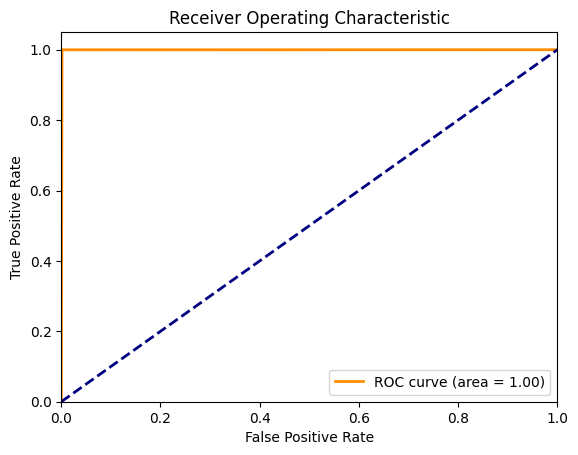

INFO :      fit progress: (5, 0.0, {'accuracy': 99.96312289592329, 'loss': 0.0, 'report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     41313\n           1       1.00      1.00      1.00    547128\n\n    accuracy                           1.00    588441\n   macro avg       1.00      1.00      1.00    588441\nweighted avg       1.00      1.00      1.00    588441\n', 'confusion_matrix': array([[ 41248,     65],
       [   152, 546976]]), 'roc_auc': 0.9991177144545836}, 294.6708321220001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=7569) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7569) 
(ClientAppActor pid=7569)             This is a deprecated feature. It will b

(ClientAppActor pid=7569) Entered client 1 function
(ClientAppActor pid=7569) model created
(ClientAppActor pid=7569) Entered client 1 function
(ClientAppActor pid=7567) Entered client 3 function
(ClientAppActor pid=7567) model created
(ClientAppActor pid=7567) Entered client 3 function
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) model created
(ClientAppActor pid=7568) Entered client 5 function
(ClientAppActor pid=7568) Evaluating model for client 5
(ClientAppActor pid=7568) Loss: 0.011760475849376702
(ClientAppActor pid=7568) Accuracy: 0.9996737157656463
(ClientAppActor pid=7569) Evaluating model for client 1
(ClientAppActor pid=7569) Loss: 0.01323053533054876
(ClientAppActor pid=7569) Accuracy: 0.9996329302363521
(ClientAppActor pid=7567) Evaluating model for client 3


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 313.45s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.014210574984663469
INFO :      		round 2: 0.013475545244077437
INFO :      		round 3: 0.012495505589962732
INFO :      		round 4: 0.014210574984663469
INFO :      		round 5: 0.014945604725249495
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9996057398834893),
INFO :      	              (2, 0.9996261326481365),
INFO :      	              (3, 0.9996533230009993),
INFO :      	              (4, 0.9996057398834893),
INFO :      	              (5, 0.9995853471188423)],
INFO :      	 'loss': [(1, 0.014210574984663469),
INFO :      	       

(ClientAppActor pid=7567) Loss: 0.01984580299582303
(ClientAppActor pid=7567) Accuracy: 0.9994493953545283
Total time taken: 114.34597516059875 seconds


In [14]:
if __name__ == "__main__":
    start_server()
    total_time = calculate_federated_learning_time(start_time, end_time)
    print(f"Total time taken: {total_time} seconds")